<a href="https://colab.research.google.com/github/Pheol9166/AIstudy/blob/main/NLP/category_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 데이터 준비
- https://github.com/freelec/ai-math-book/tree/master/02_nlp/dataset/raw_datas
- 인문/과학/경제 카테고리로 분류가 가능함

In [1]:
!pip install konlpy

In [22]:
import re
import matplotlib.pyplot as plt
import gensim
from konlpy.tag import Okt
from collections import Counter
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

In [3]:
def load_text(name: str):
  with open(f"./{name}.txt", "r") as f:
    text = f.readlines()
  return text

humanities = load_text("humanities")
economy = load_text("economy")
science = load_text("science")

humanities[:5]

['가볍지만 공허하지 않게\n',
 '소개부터 할까요. 우리에 대해 알고 싶어 하는 사람이 있을 수 있으니까. 쑥스럽습니다. 저는 메뚝씨입니다. 하는 일을 규정하기는 어려울 것 같고 표준적인 삶에 저항하는 인문학도라고 해 둘게요. 근엄하게 가르치는 인문학자 말고 가볍지만 진지한 자세로 배움에 임하고 있는 20년째 인문학도입니다.\n',
 '저는 옛날 얘기부터 하고 시작할게요. 중학교 때 처음으로 읽은 책이 기억나네요. 《꽃들에게 희망을》이라는 책이었는데 읽는 게 굉장히 힘들었어요. 어머니의 강요로 읽었거든요. 책을 보면 무지하게 졸린 사람입니다. 그래도 위안 삼아 책을 머리맡에 놓고 잡니다. 물론 책을 좋아하고 여럿 봅니다. TV 보듯이 봐요. 그런데 기억이 없어요. 읽고 나면 싹 사라져 버립니다. 이번을 계기로 책을 보는 데서 읽는 것으로 전환하고 싶습니다. 흄을 만나서 칸트가 달라졌듯, ‘얇고 넓게’에서 ‘좁고 깊게’로 독서 능력뿐 아니라 삶을 개편하고 싶습니다.\n',
 '철학으로 삶을 개편하고픈 똥팔씨의 진실함이 부디 달성되었으면 좋겠습니다.\n',
 '한방에 삶을 개편시키긴 어렵고 매일 조금씩 나를 자극하는 밤을 지새우면서 본격적으로 철학과 이어진 삶을 만들고 싶어요. 매일 밤 때로는 부드럽고 상냥하게, 때로는 불편하고 강렬하게 제 삶을 흔들어 줄 철수들을 만나는 식으로요.\n']

### 데이터 전처리

In [4]:
def clean_text(text: str) -> str:
  return re.sub(r"[^ㄱ-ㅣ가-힣\s]", "", str(text)).strip()

# 불용어 사전을 통해 제거
def remove_stopword(tokens: list[str]) -> list[str]:
  with open("./stopword.txt", "r") as f:
    stopwords = [re.sub("\n", "", text) for text in f.readlines()]
  return [token for token in tokens if token not in stopwords]

# 빈도수를 기반으로 제거
def remove_stopword_by_frequency(tokens: list[str], n: int=10) -> list[str]:
  counter = Counter(tokens)
  stopwords = [word for word, freq in counter.most_common(n)]
  return [token for token in tokens if token not in stopwords]

In [5]:
okt = Okt()

In [6]:
def preprocessing(texts: list[str]) -> list[list[str]]:
  result = []
  for text in texts:
    text = clean_text(text)
    tokens = okt.morphs(text)
    tokens = remove_stopword_by_frequency(tokens)
    result.append(tokens)
  return result

In [7]:
humanities = preprocessing(humanities)
len(humanities)

837

In [8]:
economy = preprocessing(economy)
science = preprocessing(science)

In [9]:
# 정답 레이블 추가
def make_label_data(text: list[list[str]], label_name: str) -> list[str]:
  return [label_name for i in range(len(text))]

label1 = make_label_data(humanities, "humanities")
label2 = make_label_data(economy, "economy")
label3 = make_label_data(science, "science")

In [10]:
X_data = humanities + economy + science
len(X_data)

3183

In [11]:
target = label1 + label2 + label3
len(target)

3183

### 데이터 분할 및 임베딩
- train, test 데이터 분할
- 워드 임베딩 및 tf-idf 가중치 추가

In [12]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_data, target, random_state=42)
print(len(X_train), len(X_test))

2387 796


In [13]:
# tf-idf 가중치를 활용한 단어 임베딩
dictionary = gensim.corpora.Dictionary(X_train)
corpus = [dictionary.doc2bow(txt) for txt in X_train]

tfmodel = gensim.models.TfidfModel(corpus)
tfidf_corpus = tfmodel[corpus]

num_words = len(dictionary)
X_train_tfidf = gensim.matutils.corpus2dense(tfidf_corpus, num_terms=num_words).T

In [14]:
corpus = [dictionary.doc2bow(txt) for txt in X_test]

tfmodel = gensim.models.TfidfModel(corpus)
tfidf_corpus = tfmodel[corpus]

num_words = len(dictionary)
X_test_tfidf = gensim.matutils.corpus2dense(tfidf_corpus, num_terms=num_words).T

### Softmax 회귀를 통한 다중클래스 분류

In [23]:
clf_model = LogisticRegression(multi_class= 'multinomial', C=1, penalty='l2', solver='lbfgs')
clf_model.fit(X_train_tfidf, y_train)

LogisticRegression(C=1, multi_class='multinomial')

In [24]:
y_predict = clf_model.predict(X_test_tfidf)
print(y_predict[:5])
print(y_test[:5])

['science' 'science' 'humanities' 'science' 'science']
['science', 'economy', 'humanities', 'humanities', 'science']


In [25]:
accuracy_score(y_test, y_predict)

0.7412060301507538

### Word2Vec를 활용한 PCA

In [18]:
model = Word2Vec(X_train, vector_size=300, window=3, min_count=5)
word_vectors = model.wv.vectors
word_vectors

array([[ 4.04930599e-02,  4.27976787e-01,  8.52520019e-03, ...,
        -1.78346321e-01,  2.18258873e-01, -1.14983492e-01],
       [ 3.62073444e-02,  4.15603191e-01,  5.20958425e-03, ...,
        -1.75496027e-01,  2.06943378e-01, -1.08684555e-01],
       [ 3.89419720e-02,  3.62730950e-01,  5.52763045e-03, ...,
        -1.43176690e-01,  1.87004119e-01, -9.61208493e-02],
       ...,
       [ 1.94895791e-03,  3.30735706e-02,  2.82823853e-03, ...,
        -1.36569664e-02,  1.84922703e-02, -1.08700823e-02],
       [ 7.77900498e-03,  5.37283979e-02, -3.54493735e-04, ...,
        -2.18544323e-02,  2.87860613e-02, -1.36887766e-02],
       [ 6.31481409e-03,  4.37691733e-02,  3.49103333e-03, ...,
        -1.61610506e-02,  2.16793250e-02, -1.45510854e-02]], dtype=float32)

In [19]:
# PCA
pca = PCA(n_components=2)
result = pca.fit_transform(word_vectors)
result

array([[ 3.0854983e+00, -2.9572940e-03],
       [ 2.9470093e+00, -6.2247477e-03],
       [ 2.4925969e+00,  2.7913192e-02],
       ...,
       [-6.7989391e-01, -1.5423021e-03],
       [-4.5762530e-01,  1.6020567e-03],
       [-5.5020016e-01,  5.1085302e-03]], dtype=float32)

In [20]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


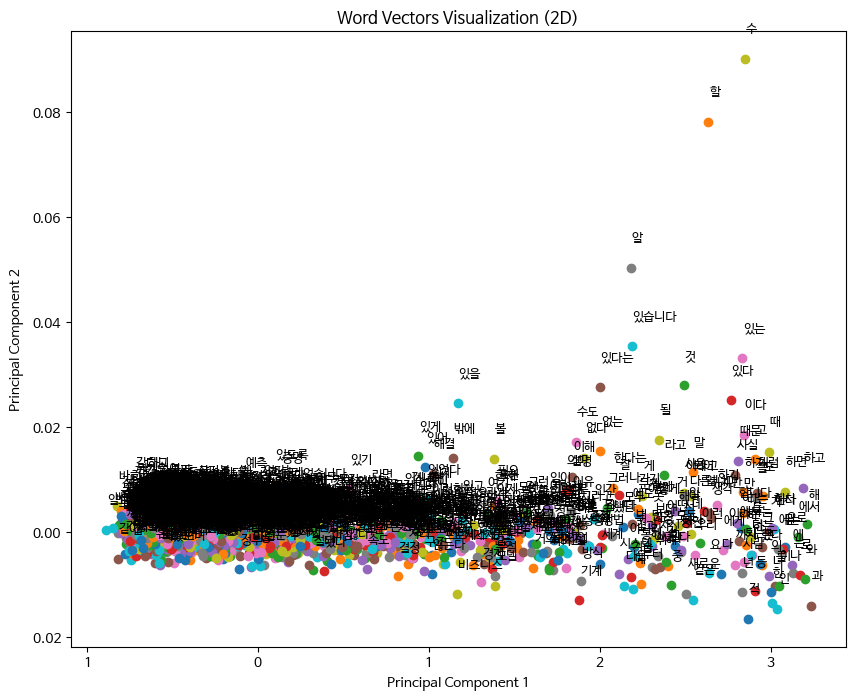

In [21]:
plt.rc('font', family='NanumBarunGothic')

plt.figure(figsize=(10, 8))
for i, word in enumerate(model.wv.index_to_key):
    plt.scatter(result[i, 0], result[i, 1])
    plt.text(result[i, 0] + 0.005, result[i, 1] + 0.005, word, fontsize=9)

plt.title('Word Vectors Visualization (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()